## Problem Statement

* The assigned task was to find out what makes a movie get a strong rating
* "Tell" Netflix about my findings so that they can recommend movies to its subscribers

## Goals of Study

* Webscrape relevant information
* Transform information into features
* Determine what features are significant

In [137]:
from imdbpie import Imdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from BeautifulSoup import BeautifulSoup
import requests
import time
% matplotlib inline

imdb = Imdb()

In [20]:
#I used a python library to get the top 250 movies for me

data=imdb.top_250()
df=pd.DataFrame(data)
del df['image']

In [21]:
#This was the format of the imdb data; there is not a lot going on, so I will scrape extra information from Wiki

df[df['title']=="Ben-Hur"]

,can_rate,num_votes,rating,tconst,title,type,year
191,True,164629,8.1,tt0052618,Ben-Hur,feature,1959


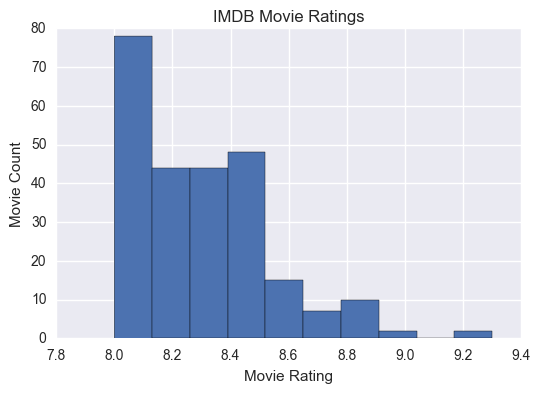

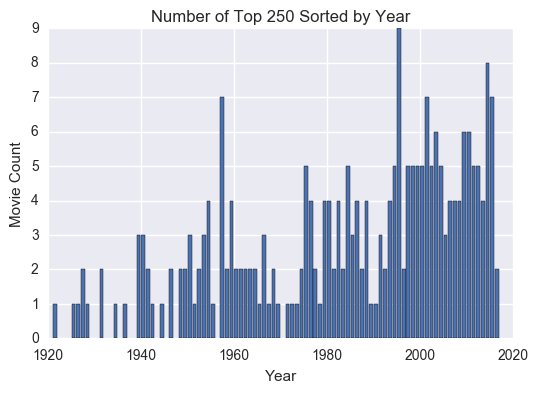

In [120]:
plt.hist(df["rating"])
plt.title("IMDB Movie Ratings")
plt.xlabel("Movie Rating")
plt.ylabel("Movie Count")
plt.show()
plt.bar(df.groupby('year')['rating'].count().to_frame().reset_index()['year'],
              df.groupby('year')['rating'].count().to_frame().reset_index()['rating'])
plt.title("Number of Top 250 Sorted by Year")
plt.xlabel("Year")
plt.ylabel("Movie Count")
plt.show()

In [24]:
#This is my Wiki webscraping code. I search for wiki/'Movie Name' in a variety of three ways.
#If one methodology fails to return information for a movie, the next methodology is used.
#The Wiki information being extracted is the data in the box in the upper right hand side of nearly every wiki entry

def get_movie_info(movie_name):
    base_url='https://en.wikipedia.org/wiki/'
    movie_name_url=base_url+movie_name.replace(" ","_")+"_(film)"
    html=requests.get(movie_name_url)
    soup=BeautifulSoup(html.text)
    i=len(soup.findAll('td',{'style':'line-height:1.3em;'}))-1
    information={"URL":movie_name_url}
    for count in range(i+1):
        information[soup.findAll('th', {'scope':"row"})[count].text]=\
                            soup.findAll('td',{'style':'line-height:1.3em;'})[count].text
    for count in range(i):
        temp=""
        length=len(soup.findAll('td',{'style':'line-height:1.3em;'})[count]('li'))-1
        if length<1:
            temp=soup.findAll('td',{'style':'line-height:1.3em;'})[i].text
        else:
            for x in range(length):
                if x==0:
                    temp+=soup.findAll('td',{'style':'line-height:1.3em;'})[count]('li')[x].text
                else:
                    temp+=", "+soup.findAll('td',{'style':'line-height:1.3em;'})[count]('li')[x].text
            information[soup.findAll('th', {'scope':"row"})[count].text]=temp
    return information
def get_movie_info_with_year(movie_name,year):
    base_url='https://en.wikipedia.org/wiki/'
    movie_name_url=base_url+movie_name.replace(" ","_")+"_("+year+" film)"
    html=requests.get(movie_name_url)
    soup=BeautifulSoup(html.text)
    i=len(soup.findAll('td',{'style':'line-height:1.3em;'}))-1
    information={"URL":movie_name_url}
    for count in range(i+1):
        information[soup.findAll('th', {'scope':"row"})[count].text]=\
                            soup.findAll('td',{'style':'line-height:1.3em;'})[count].text
    for count in range(i):
        temp=""
        length=len(soup.findAll('td',{'style':'line-height:1.3em;'})[count]('li'))-1
        if length<1:
            temp=soup.findAll('td',{'style':'line-height:1.3em;'})[i].text
        else:
            for x in range(length):
                if x==0:
                    temp+=soup.findAll('td',{'style':'line-height:1.3em;'})[count]('li')[x].text
                else:
                    temp+=", "+soup.findAll('td',{'style':'line-height:1.3em;'})[count]('li')[x].text
            information[soup.findAll('th', {'scope':"row"})[count].text]=temp
    return information

def get_movie_info_no_film(movie_name):
    base_url='https://en.wikipedia.org/wiki/'
    movie_name_url=base_url+movie_name.replace(" ","_")
    html=requests.get(movie_name_url)
    soup=BeautifulSoup(html.text)
    i=len(soup.findAll('td',{'style':'line-height:1.3em;'}))-1
    information={"URL":movie_name_url}
    for count in range(i+1):
        information[soup.findAll('th', {'scope':"row"})[count].text]=\
                            soup.findAll('td',{'style':'line-height:1.3em;'})[count].text
    for count in range(i):
        temp=""
        length=len(soup.findAll('td',{'style':'line-height:1.3em;'})[count]('li'))-1
        if length<1:
            temp=soup.findAll('td',{'style':'line-height:1.3em;'})[i].text
        else:
            for x in range(length):
                if x==0:
                    temp+=soup.findAll('td',{'style':'line-height:1.3em;'})[count]('li')[x].text
                else:
                    temp+=", "+soup.findAll('td',{'style':'line-height:1.3em;'})[count]('li')[x].text
            information[soup.findAll('th', {'scope':"row"})[count].text]=temp
    return information

In [25]:
#Uses the first methodology to extract information for the corresponding IMDB title

#####
##### ONLY RUN IF YOU NEED TO GET ALL OF THE MOVIE INFORMATION
#####


movie_dict={}
for number in range(len(df)):
    movie=df.loc[number,'title']
    movie_dict[movie]=get_movie_info(movie)


In [26]:
#Puts the information of the first scrape into a dataframe

movie_information=pd.DataFrame(movie_dict).T

In [27]:
#Checks to see which movies are missing relevant data. Uses second methodology to try and get that data
#Then puts new data into the missing fields of the dataframe

#####
##### ONLY RUN IF YOU NEED TO GET ALL OF THE MOVIE INFORMATION
#####

movie_information=movie_information.reset_index()
movie_information=movie_information.rename(columns={'index':'title'})
titles=movie_information[pd.isnull(movie_information['Budget'])]['title']

movie_dict2={}
rows=df.iloc[[0,1]].copy()
rows=rows.drop(df.index[[0,1]])
for name in titles:
    rows=pd.concat([rows,df[df['title']==name]])
for number in range(len(rows)):
    movie=df.loc[number,'title']
    year=df.loc[number,'year']
    movie_dict2[movie]=get_movie_info_with_year(movie,year)
movie_information=pd.concat([movie_information,pd.DataFrame(movie_dict2).T.reset_index().rename(
                            columns={'index':'title'})])
movie_information=movie_information.reset_index()
del movie_information['index']
titles=movie_information[pd.isnull(movie_information['Budget'])]['title']

In [28]:
#Checks to see which movies are missing relevant data. Uses third methodology to try and get that data
#Then puts new data into the missing fields of the dataframe

#####
##### ONLY RUN IF YOU NEED TO GET ALL OF THE MOVIE INFORMATION
#####
movie_dict3={}
rows=df.iloc[[0,1]].copy()
rows=rows.drop(df.index[[0,1]])
for name in titles:
    rows=pd.concat([rows,df[df['title']==name]])
for number in range(len(rows)):
    movie=df.loc[number,'title']
    movie_dict3[movie]=get_movie_info_no_film(movie)
movie_information=pd.concat([movie_information,pd.DataFrame(movie_dict3).T.reset_index().rename(
                            columns={'index':'title'})])
movie_information=movie_information.reset_index()
movie_information['index']=movie_information['title'].copy()
del movie_information['title']
movie_information=movie_information.rename(columns={'index':'title'})

In [29]:
#Copy extracted wiki data so unwanted changes in dataframe don't result in a rescrape
copy=movie_information.copy()

In [30]:
#Resets dataframe to the copy
movie_information=copy.copy()

In [31]:
#Functions used for cleaning the data 
def billion_conversion(dummy):
    return_value=0
    if 'billion' in str(dummy):
        return_value=dummy[:5]
        return float(return_value)*1000
    else:
        return dummy

def comma_period_conjoined(dummy):
    if len(dummy)>10:
        value=dummy.split(" ")[0]
        comma_count=value.count(",")
        period_count=value.count(".")
        loop_value=""
        first=0
        if comma_count>0:
            first=len(value.split(",")[0])
            for i in range(len(value.split(","))/2+1):
                loop_value+=value.split(",")[i]
        if period_count>0:
            first=len(value.split(".")[0])
            for i in range(len(value.split("."))/2+1):
                loop_value+=value.split(".")[i]
        loop_value=loop_value[:-first]
        return loop_value
    else:
        return dummy
    
def remove_remaining_nonsense(value):
    keep='0123456789.,'
    return_string=""
    i=0
    while i < len(value):
        if value[i] in keep:
            return_string+=value[i]
            i+=1
        else:
            i=len(value)
    return return_string

def remove_spacing_brackets(value):
    new=value
    i=0
    while i<len(new):
        if new[i]==" ":
            new=new[i+1:]
            i+=1
        else:
            i=len(new)
    #new=new.split(" ")[0]
    new=new.split("(")[0]
    new=new.split("[")[0]
    return new

def thou_to_mil(value):
    if "," in value:
        return float(value.replace(",",""))/1000000
    else:
        return value

In [127]:
# Data cleaning section-->Primarily concerned with budget, box office, and language columns
#Some movies needed to have info hard coded due to conditional difficulties with the information extracted
#A lot of unneeded columns were created in the webscraping process, those are eliminated here

merged_dfs=pd.merge(df,movie_information,on='title')
merged_dfs=merged_dfs.sort_values('Budget')
merged_dfs=merged_dfs.drop_duplicates(['title'])
merged_dfs=merged_dfs.reset_index()
del merged_dfs['index']
box_office={'Seven Samurai':'2.6','Princess Mononoke':'159.4',"Spirited Away":'289.1',"Grave of the Fireflies":'5.0',
           "The Intouchables":'426.6','3 Idiots':'58',"Children of Heaven":'1.6','Cinema Paradiso':'12',
           'The Lord of the Rings: The Return of the King':'1119','Alien':'104.9','Trainspotting':'2.25',
           'Star Wars: Episode V - The Empire Strikes Back':'535','The Dark Knight':'1005','Incendies':'16',
           'The Dark Knight Rises':'1085','It Happened One Night':'2.5','Touch of Evil':'2.24',
           'Gone with the Wind':'390','Metropolis':'7'}
budget    ={'Seven Samurai':'1.2','Princess Mononoke': '20.1',"Spirited Away":'18.12',"Grave of the Fireflies":'3.7',
           "The Intouchables":'10.8','3 Idiots':'8.2',"Children of Heaven":'180,000','Cinema Paradiso':'5',
           'Downfall':'20','The Grand Budapest Hotel':'31','Lock, Stock and Two Smoking Barrels':'1.35',
            'Trainspotting':'2.2'}
lang_change=[u'English', u'ItalianEnglish', u'EnglishRussianVietnameseFrench', u'EnglishGermanFrench', 
             u'ItalianGermanEnglish', u'English, Polish, German, Russian, French', u'English, German',
    u'EnglishGerman', u'DanishEnglish',u'EnglishYiddish', u'Italian',u'ItalianEnglishPortugueseSicilian',
            u'Silent filmEnglish intertitles', u'Silent filmGermanintertitles',u'Hindi[1]', 
             u'\xa530.4 billion[4](US$289.1 million)[5]']
for name in box_office.keys():
    i=0
    while i<len(merged_dfs):
        if merged_dfs.loc[i,'title']==name:
            merged_dfs.set_value(i,'Box office',box_office[name])
        i+=1
for name in budget.keys():
    i=0
    while i<len(merged_dfs):
        if merged_dfs.loc[i,'title']==name:
            merged_dfs.set_value(i,'Budget',budget[name])
        i+=1

        
        
merged_dfs=merged_dfs[pd.notnull(merged_dfs['Budget'])]
merged_dfs=merged_dfs[pd.notnull(merged_dfs['Box office'])]
merged_dfs=merged_dfs[pd.notnull(merged_dfs['Running time'])]
merged_dfs=merged_dfs[pd.notnull(merged_dfs['Country'])]
merged_dfs['Country']=merged_dfs['Country'].apply(lambda x: x.replace("[1]","").replace("[2]","").replace("[3]","")\
    .replace("[4]","").replace("[5]","").replace("[6]","").replace("[7]","").replace("[8]","").replace("[9]",""))
merged_dfs['Running time']=merged_dfs['Running time'].apply(lambda x: x.split(" ")[0])
merged_dfs['Budget']=merged_dfs['Budget'].apply(lambda x: x.replace("$",""))
merged_dfs['Budget']=merged_dfs['Budget'].apply(lambda x: x.replace("[1]","").replace("[2]","").replace("[3]","")\
    .replace("[4]","").replace("[5]","").replace("[6]","").replace("[7]","").replace("[8]","").replace("[9]",""))
merged_dfs['Budget']=merged_dfs['Budget'].apply(lambda x: x.split("million")[0])
merged_dfs['Budget']=merged_dfs['Budget'].apply(lambda x: x.replace("&#160;",""))
merged_dfs['Budget']=merged_dfs['Budget'].apply(lambda x: remove_spacing_brackets(x))
merged_dfs['Budget']=merged_dfs['Budget'].apply(lambda x: remove_remaining_nonsense(x)) 
merged_dfs['Budget']=merged_dfs['Budget'].apply(lambda x: thou_to_mil(x)) 


merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: x.replace("$",""))
merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: x.replace("[1]","").replace("[2]","").\
                                                        replace("[3]","")\
    .replace("[4]","").replace("[5]","").replace("[6]","").replace("[7]","").replace("[8]","").replace("[9]",""))
merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: x.split("million")[0])
merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: x.replace("&#160;",""))
merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: x[:2]if x==4 else x )
merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: remove_spacing_brackets(x))
#merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: x.split(".")[0])
#merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: x.split(",")[0] if len(x.split(",")[0])==1 else x )
merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: comma_period_conjoined(x))
merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: remove_remaining_nonsense(x))
merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: billion_conversion(x))
merged_dfs['Box office']=merged_dfs['Box office'].apply(lambda x: thou_to_mil(x))

merged_dfs['Running time']=merged_dfs['Running time'].apply(lambda x: x.split(" ")[0])
merged_dfs=merged_dfs.drop_duplicates(['title'])
merged_dfs=merged_dfs.drop_duplicates(['title'])
merged_dfs=merged_dfs.reset_index()
merged_dfs['index']=merged_dfs['title'].copy()
del merged_dfs['title']
merged_dfs['Production Company']=[x if pd.isnull(y) else y for x,y in 
                    zip(merged_dfs['Productioncompany'].copy(),merged_dfs['Productioncompanies'].copy())]
del merged_dfs['Productioncompanies']
del merged_dfs['Productioncompany']
merged_dfs['Edit Guy']=[x if pd.isnull(y) else y for x,y in 
                    zip(merged_dfs['Edited by'].copy(),merged_dfs['Editor'].copy())]
del merged_dfs['Edited by']
del merged_dfs['Editor']
merged_dfs=merged_dfs.rename(columns={'index':'title'})
del merged_dfs['type']
del merged_dfs['Cantonese']
del merged_dfs['can_rate']
del merged_dfs['Colourist']
del merged_dfs['Revised Romanization']
del merged_dfs['Simplified']
del merged_dfs['Traditional']
del merged_dfs['Artists']
del merged_dfs['Date&#160;of publication']
del merged_dfs['Publisher']
del merged_dfs['Hepburn']
del merged_dfs['Distributed by']
del merged_dfs['Hangul']
del merged_dfs['Hanja']
del merged_dfs['Issues']
del merged_dfs['Japanese']
del merged_dfs['Letterer']

i=0
while i<len(merged_dfs):
    if merged_dfs.loc[i,'Language'] in lang_change:
        merged_dfs.set_value(i,'Language','English')
        i+=1
    else:
        i+=1
merged_dfs['Budget']=merged_dfs['Budget'].astype(float)
merged_dfs['Box office']=merged_dfs['Box office'].astype(float)

#---------------------------------------------------------------

merged_dfs_copy=merged_dfs.copy()

In [128]:
merged_dfs["Language"].unique()

array(['English', u'French', u'Japanese', u'Spanish', u'German',
       u'Silent film', u'Portuguese', nan, u'Persian', u'FrenchArabic'], dtype=object)

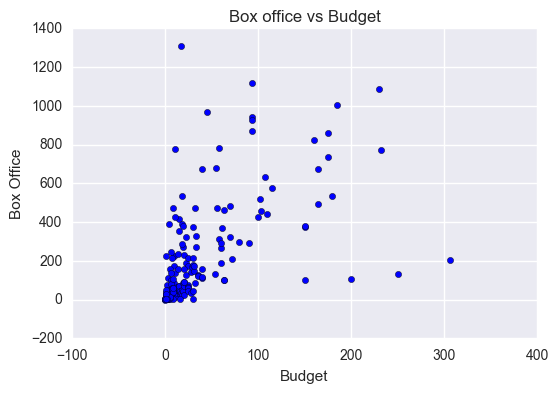

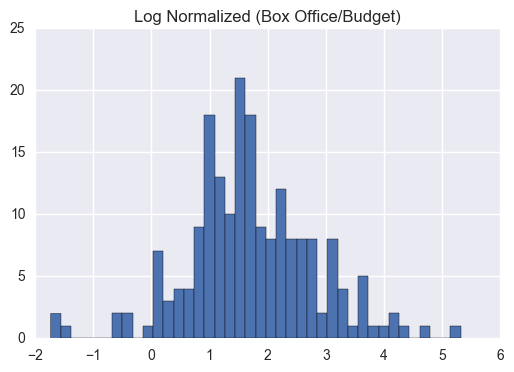

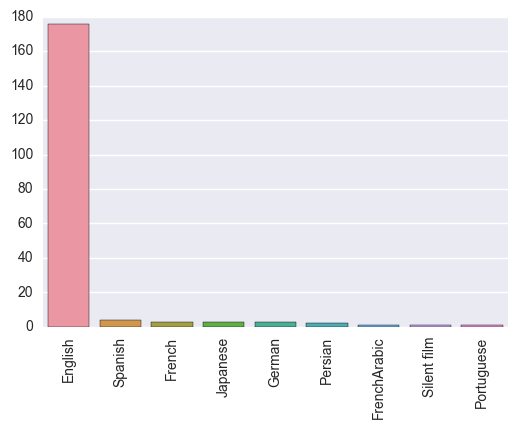

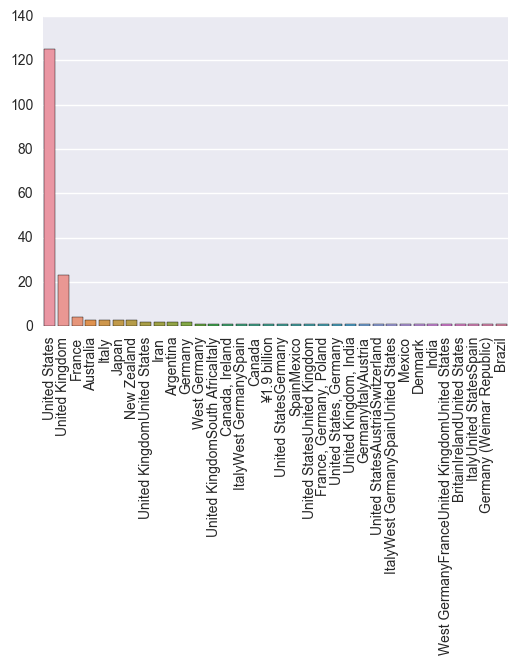

In [130]:
# EDA
#The first plot is of Box office vs Budget. There doesn't seem to be a direct relationship here
#The second plot attempts to make one. It wasn't used though because it doesn't have a thorough relationship to score
#The third plot shows if the movies were available in english; if not, then the primary language
    #There don't seem to be any significant factors here, as we should expect. IMDB is American. (Note: I added in non
    #English movies and missing language movies; the change was less than 10 movies. Acceptable given the magnitudes.)
#The final plot shows the various countries the movies are from. Again, strong bias to US and UK due to the languages 
#the movies were primarily made in. (I'm not putting this plot on my blog, so I am not going to tidy the values)

plt.scatter(merged_dfs['Budget'],merged_dfs['Box office'])
plt.ylim(-200,1400)
plt.xlim(-100,400)
plt.ylabel("Box Office")
plt.xlabel("Budget")
plt.title("Box office vs Budget")
plt.show()
plt.hist(np.log(merged_dfs['Box office']/merged_dfs['Budget']),bins=40)
plt.title("Log Normalized (Box Office/Budget)")
plt.show()
sns.barplot(x=merged_dfs["Language"].value_counts().index,y=merged_dfs["Language"].value_counts().values)
plt.xticks(rotation=90)
plt.show()
sns.barplot(x=merged_dfs["Country"].value_counts().index,y=merged_dfs["Country"].value_counts().values)
plt.xticks(rotation=90);
plt.show()

In [156]:
def create_X_y(use_super,use_mega,use_ultra,Actors,Production_Company,Producer,Editor,Composer):
    super_cols=create_super(Actors,Production_Company,Producer,Editor,Composer)
    mega_cols =create_mega (Actors,Production_Company,Producer,Editor,Composer)
    ultras=create_add_columns(Actors,Production_Company,Producer,Editor,Composer)
    base=[u'Box office']
    if use_ultra:
        for ultra in ultras:
            base.append(ultra)
    init_cols=base
    dumm_cols=[]
    dele_cols=[]

    if use_super:
        init_cols.extend(super_cols[0])
        dumm_cols.extend(super_cols[0])
        dele_cols.extend(super_cols[0])
        dele_cols.extend(super_cols[1])
    if use_mega:
        init_cols.extend(mega_cols[0])
        dumm_cols.extend(mega_cols[0])
        dele_cols.extend(mega_cols[0])
        dele_cols.extend(mega_cols[1])


    y=merged_dfs['rating'].copy()
    X=merged_dfs[init_cols].copy()

    if len(dumm_cols)>0:
        X=pd.concat([X,pd.get_dummies(X[dumm_cols])],axis=1)

    for col in dele_cols:
        del X[col]
    
    return X,y

def create_super(actors,production_company,producer,editor,composer):
    sc1=[]
    sc2=[]
    if Actors:
        sc1.append(u'Super Actors')
        sc2.append(u'Super Actors_No')
    if Production_Company:
        sc1.append(u'Super Production Company')
        sc2.append(u'Super Production Company_No')
    if Producer:
        sc1.append(u'Super Producer')
        sc2.append(u'Super Producer_No')
    if Editor:
        sc1.append(u'Super Editor')
        sc2.append(u'Super Editor_No')
    if Composer:
        sc1.append(u'Super Composer')
        sc2.append(u'Super Composer_No')
    master=[sc1,sc2]
    return master
        
def create_mega (actors,production_company,producer,editor,composer):
    mc1=[]
    mc2=[]
    if Actors:
        mc1.append(u'Mega Actors')
        mc2.append(u'Mega Actors_No')
    if Production_Company:
        mc1.append(u'Mega Production Company')
        mc2.append(u'Mega Production Company_No')
    if Producer:
        mc1.append(u'Mega Producer')
        mc2.append(u'Mega Producer_No')
    if Editor:
        mc1.append(u'Mega Editor')
        mc2.append(u'Mega Editor_No')
    if Composer:
        mc1.append(u'Mega Composer')
        mc2.append(u'Mega Composer_No')
    master=[mc1,mc2]
    return master

def create_add_columns(Actors,Production_Company,Producer,Editor,Composer):
    ###List is initiated with correct actors; everyone else is added to the list as listed. 
    #We ignore produced by because
    # in most cases it is a diplicate from directed by.
    actor_list=[]
    for actors in merged_dfs['Starring']:
        for actor in actors.split(", "):
            actor_list.append(actor)
            
    super_min=2
    super_list=[x for x in pd.DataFrame([actor_list,actor_list]).T[0].value_counts()[pd.DataFrame([actor_list,\
                    actor_list]).T[0].value_counts()>super_min].reset_index()['index'].copy()]
    super_list.extend([x for x in merged_dfs['Directed by'].value_counts()[merged_dfs['Directed by']\
                                    .value_counts()>super_min].to_frame().index.copy()])
    super_list.extend([x for x in merged_dfs['Edit Guy'].value_counts()[merged_dfs['Edit Guy']\
                                    .value_counts()>super_min].to_frame().index.copy()])
    super_list.extend([x for x in merged_dfs['Produced by'].value_counts()[merged_dfs['Produced by']\
                                    .value_counts()>super_min].to_frame().index.copy()])
    super_list.extend([x for x in merged_dfs['Production Company'].value_counts()[merged_dfs['Production Company']\
                                    .value_counts()>super_min].to_frame().index.copy()])
    super_list.extend([x for x in merged_dfs['Music by'].value_counts()[merged_dfs['Music by']\
                                    .value_counts()>super_min].to_frame().index.copy()])
    merged_dfs["Super Actors"]=merged_dfs['Starring'].apply(lambda x: super_actor(x,super_list))
    merged_dfs["Super Production Company"]=merged_dfs['Production Company'].apply(lambda x: \
                                                                                  super_single(x,super_list))
    merged_dfs["Super Producer"]=merged_dfs['Produced by'].apply(lambda x: super_single(x,super_list))
    merged_dfs["Super Editor"]=merged_dfs['Edit Guy'].apply(lambda x: super_single(x,super_list))
    merged_dfs["Super Composer"]=merged_dfs['Edit Guy'].apply(lambda x: super_single(x,super_list))


    mega_min=3
    mega_list=[x for x in pd.DataFrame([actor_list,actor_list]).T[0].value_counts()[pd.DataFrame([actor_list,\
                    actor_list]).T[0].value_counts()>mega_min].reset_index()['index'].copy()]
    mega_list.extend([x for x in merged_dfs['Directed by'].value_counts()[merged_dfs['Directed by']\
                                    .value_counts()>mega_min].to_frame().index.copy()])
    mega_list.extend([x for x in merged_dfs['Edit Guy'].value_counts()[merged_dfs['Edit Guy']\
                                    .value_counts()>mega_min].to_frame().index.copy()])
    mega_list.extend([x for x in merged_dfs['Produced by'].value_counts()[merged_dfs['Produced by']\
                                    .value_counts()>mega_min].to_frame().index.copy()])
    mega_list.extend([x for x in merged_dfs['Production Company'].value_counts()[merged_dfs['Production Company']\
                                    .value_counts()>mega_min].to_frame().index.copy()])
    mega_list.extend([x for x in merged_dfs['Music by'].value_counts()[merged_dfs['Music by']\
                                    .value_counts()>mega_min].to_frame().index.copy()])
    merged_dfs["Mega Actors"]=merged_dfs['Starring'].apply(lambda x: super_actor(x,mega_list))
    merged_dfs["Mega Production Company"]=merged_dfs['Production Company'].apply(lambda x: \
                                                                                 mega_single(x,mega_list))
    merged_dfs["Mega Producer"]=merged_dfs['Produced by'].apply(lambda x: mega_single(x,mega_list))
    merged_dfs["Mega Editor"]=merged_dfs['Edit Guy'].apply(lambda x: mega_single(x,mega_list))
    merged_dfs["Mega Composer"]=merged_dfs['Edit Guy'].apply(lambda x: mega_single(x,mega_list))

    ultra_min=5
    ultra_list=[]
    ultra_list=[x for x in pd.DataFrame([actor_list,actor_list]).T[0].value_counts()[pd.DataFrame([actor_list,\
                    actor_list]).T[0].value_counts()>ultra_min].reset_index()['index'].copy()]
    ultra_list.extend([x for x in merged_dfs['Directed by'].value_counts()[merged_dfs['Directed by']\
                                    .value_counts()>ultra_min].to_frame().index.copy()])
    ultra_list.extend([x for x in merged_dfs['Edit Guy'].value_counts()[merged_dfs['Edit Guy']\
                                    .value_counts()>ultra_min].to_frame().index.copy()])
    ultra_list.extend([x for x in merged_dfs['Produced by'].value_counts()[merged_dfs['Produced by']\
                                    .value_counts()>ultra_min].to_frame().index.copy()])
    ultra_list.extend([x for x in merged_dfs['Production Company'].value_counts()[merged_dfs['Production Company']\
                                    .value_counts()>ultra_min].to_frame().index.copy()])
    ultra_list.extend([x for x in merged_dfs['Music by'].value_counts()[merged_dfs['Music by']\
                                    .value_counts()>ultra_min].to_frame().index.copy()])
    ultra_unique=pd.DataFrame(ultra_list,columns=["List"])["List"].unique()
    for x in ultra_unique:
        temp=[]
        for lookup in range(len(merged_dfs['Starring'])):
            #I need to check whether the name is any of the appropriate columns
            if ultra_check(x,lookup):
                bin_label=ultra_type(x,lookup)
                if Actors and (bin_label=='Starring'):
                    temp.append(1)
                elif Production_Company and (bin_label=='Production Company'):
                    temp.append(1)
                elif Producer and (bin_label=='Produced by'):
                    temp.append(1)
                elif Editor and (bin_label=='Edit Guy'):
                    temp.append(1)
                elif Composer and (bin_label=='Music by'):
                    temp.append(1)
                else:
                    temp.append(0)
            else:
                temp.append(0)
        merged_dfs[x]=temp
    return ultra_unique

#Here are my automated functions for creating a dataframe to use for X and y. 
#I automated these due to the nature of the variables I was curious to test.
#I wanted to see whether repeated presence in top movies would correspond to an increased probability of
#being rate a top movie (for actors, editors, producers, production companies, and composers)
#I automated this process because of the inaccuracies and tediousness of making these manually

def super_actor(starring_list,super_list):
    actors=starring_list.split(",")
    return_value="No"
    for actor in actors:
        if actor in super_list:
            return_value="Yes"
    return return_value

def super_single(l,super_list):
    return_value="No"
    if l in super_list:
        return_value="Yes"
    return return_value

def mega_actor(starring_list,mega_list):
    actors=starring_list.split(",")
    return_value="No"
    for actor in actors:
        if actor in mega_list:
            return_value="Yes"
    return return_value

def mega_single(l,mega_list):
    return_value="No"
    if l in mega_list:
        return_value="Yes"
    return return_value

def ultra_check(ultra_name,lookup_num):
    return_value=False
    if ultra_name in merged_dfs.loc[lookup_num,"Starring"]:
        return_value=True
    elif ultra_name in merged_dfs['Production Company']:
        if ultra_name in merged_dfs.loc[lookup_num,"Production Company"]:
            return_value=True
    elif ultra_name in merged_dfs['Produced by']:
        if ultra_name in merged_dfs.loc[lookup_num,"Produced by"]:
            return_value=True
    elif ultra_name in merged_dfs['Edit Guy']:
        if ultra_name in merged_dfs.loc[lookup_num,"Edit Guy"]:
            return_value=True
    elif ultra_name in merged_dfs['Music by']:
        if ultra_name in merged_dfs.loc[lookup_num,"Music by"]:
            return_value=True
    return return_value

def ultra_type(ultra_name,lookup_num):
    return_value=""
    if ultra_name in merged_dfs.loc[lookup_num,"Starring"]:
        return_value='Starring'
    elif ultra_name in merged_dfs.loc[lookup_num,"Production Company"]:
        return_value="Production Company"
    elif ultra_name in merged_dfs.loc[lookup_num,"Produced by"]:
        return_value="Produced by"
    elif ultra_name in merged_dfs.loc[lookup_num,"Edit Guy"]:
        return_value="Edit Guy"
    elif ultra_name in merged_dfs['Music by']:
        if ultra_name in merged_dfs.loc[lookup_num,"Music by"]:
            return_value="Music by"
    return return_value

In [61]:
#This cell is here to quickly ensure changes in the automation formulas work correctly
Super=True
Mega =True
Ultra=True
Actors=False
Production_Company=True
Producer=False
Editor=False
Composer=True

merged_dfs=merged_dfs_copy.copy()

X,y=create_X_y(Super,Mega,Ultra,Actors,Production_Company,Producer,Editor,Composer)

-0.123897161599
-0.123897161599


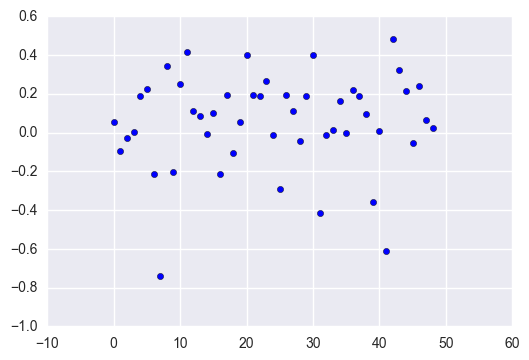

In [159]:
#Here, we see the beauty of the automation formulas. We can check every single possible combination to see if there
#is predictive significance. The idea behind this was to find the best linear regressor booleans, and implement them 
#in the classification section. Unfortunately, the best booleans for the regressors were not necessarily the best
#booleans for the classifiers. NOTE: Don't try to run this section, it will take at least 20 minutes on i7 CPUs.

linregbest=[100.,True,True,True,True,True,True,True,True,[]]
linregtemp=100.
booleans=[True,False]
for a in booleans:
    Super=a
    for b in booleans:
        Mega=b
        for c in booleans:
            Ultra=c
            for d in booleans:
                Actors=d
                for e in booleans:
                    Production_Company=e
                    for f in booleans:
                        Producer=f
                        for g in booleans:
                            Editor=g
                            for h in booleans:
                                Composer=h
                                merged_dfs=merged_dfs_copy.copy()
                                X,y=create_X_y(Super,Mega,Ultra,Actors,Production_Company,Producer,\
                                            Editor,Composer)
                                x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=1)
                                lr=LinearRegression()
                                lr.fit(x_train,y_train)
                                predlr=lr.predict(x_test)
                                linregtemp=lr.score(x_test,y_test)
                                print linregtemp
                                if np.abs(linregtemp)<np.abs(linregbest[0]):
                                    linregbest=[linregtemp,Super,Mega,Ultra,Actors,Production_Company,\
                                            Producer,Editor,Composer,predlr]
print linregbest[0]
plt.scatter(range(len(linregbest[-1])),linregbest[-1]-y_test);

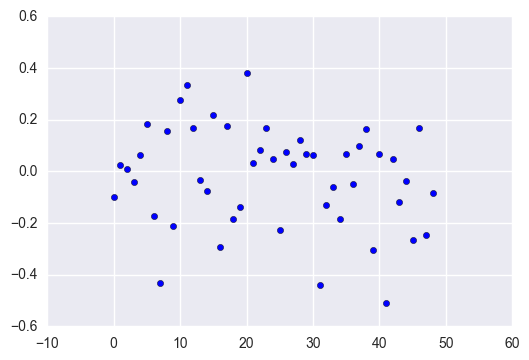

In [63]:
#Plotting the results above
plt.scatter(range(len(linregbest[-1])),linregbest[-1]-y_test);

In [153]:
#Analysis
#These are my analysis formulas. There is one for binning y_values, one for making classifications and printing
#reports, anotherone for making clsasifications and printing reports using gridsearch, and one for 
#creating ROC plots. 

def binned_y(y_list,zeta):
    new_list=[]
    for value in y_list:
        temp=int(value*zeta)#/float(zeta)
        new_list.append(temp)
    return new_list    
    
def run_regressions_and_print(bins,x_train,x_test,y_train,y_test):
    models=[]
    logreg=LogisticRegressionCV(cv=3)
    params={'penalty':['l2'],"Cs":range(4,7)}
    gs=GridSearchCV(logreg,params)
    gs.fit(x_train,y_train)
    logreg=LogisticRegressionCV(cv=3,Cs=gs.best_params_['Cs'],penalty=gs.best_params_['penalty'])
    logreg.fit(x_train,y_train)
    predlogreg=logreg.predict(x_test)
    print "LogReg Score:"
    print "   ",logreg.score(x_test,y_test)
    print pd.DataFrame(confusion_matrix(y_test,predlogreg),columns=[logreg.classes_/float(bins-1)],
                 index=[logreg.classes_/float(bins-1)])
    print gs.best_params_,"\n"
    models.append([logreg.decision_function(x_test),"LogReg"])
    #--------
    
    knn=KNeighborsClassifier()
    params={'n_neighbors':range(3,20),'weights':['uniform','distance']}
    gs=GridSearchCV(knn,params)
    gs.fit(x_train,y_train)
    knn=KNeighborsClassifier(n_neighbors=gs.best_params_['n_neighbors'],weights=gs.best_params_['weights'])
    knn.fit(x_train,y_train)
    predknn=knn.predict(x_test)
    print "Knn Score:"
    print "   ",knn.score(x_test,y_test)
    print pd.DataFrame(confusion_matrix(y_test,predknn),columns=[logreg.classes_/float(bins-1)],
                 index=[logreg.classes_/float(bins-1)])
    print gs.best_params_,"\n"
    models.append([knn.predict_proba(x_test),"KNN"])
    #--------
    
    rf=RandomForestClassifier()
    params={'n_estimators':range(4,15),'min_samples_leaf':range(3,7)}
    gs=GridSearchCV(rf,params)
    gs.fit(x_train,y_train)
    rf=RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'],\
                              min_samples_leaf=gs.best_params_['min_samples_leaf'])
    rf.fit(x_train,y_train)
    predrf=rf.predict(x_test)
    print "Random Forest Score:"
    print "   ",rf.score(x_test,y_test)
    print pd.DataFrame(confusion_matrix(y_test,predrf),columns=[logreg.classes_/float(bins-1)],
                 index=[logreg.classes_/float(bins-1)])
    print gs.best_params_,"\n"
    print (pd.DataFrame([x_test.columns,rf.feature_importances_],index=["Feature","Importance"]).T.sort(\
        'Importance',ascending=False))
    print
    models.append([rf.predict_proba(x_test),"Random Forest"])
    #--------
    
    et=ExtraTreesClassifier()
    params={'n_estimators':range(4,15),'min_samples_leaf':range(3,7)}
    gs=GridSearchCV(et,params)
    gs.fit(x_train,y_train)
    et=ExtraTreesClassifier(n_estimators=gs.best_params_['n_estimators'],\
                              min_samples_leaf=gs.best_params_['min_samples_leaf'])
    et.fit(x_train,y_train)
    predet=et.predict(x_test)
    print "Extra Trees Score:"
    print "   ",et.score(x_test,y_test)
    print pd.DataFrame(confusion_matrix(y_test,predet),columns=[logreg.classes_/float(bins-1)],
                 index=[logreg.classes_/float(bins-1)])
    print gs.best_params_,"\n"
    print (pd.DataFrame([x_test.columns,et.feature_importances_],index=["Feature","Importance"]).T.sort(\
        'Importance',ascending=False))
    print
    models.append([et.predict_proba(x_test),"Extra Trees"])
    #--------
    
    gb=GradientBoostingClassifier()
    params={'n_estimators':range(5,20,1),'max_depth':range(1,5)}
    gs=GridSearchCV(gb,params)
    gs.fit(x_train,y_train)
    gb=GradientBoostingClassifier(n_estimators=gs.best_params_['n_estimators'],\
                                 max_depth=gs.best_params_['max_depth'])
    gb.fit(x_train,y_train)
    predgb=gb.predict(x_test)
    print "Gradient Boosting Score:"
    print "   ",gb.score(x_test,y_test)
    print (pd.DataFrame(confusion_matrix(y_test,predgb),columns=[logreg.classes_/float(bins-1)],
                 index=[logreg.classes_/float(bins-1)]))
    print gs.best_params_,"\n"
    models.append([gb.decision_function(x_test),"Gradient Boosting"])
    print (pd.DataFrame([x_test.columns,gb.feature_importances_],index=["Feature","Importance"]).T.sort(\
        'Importance',ascending=False))
    print 
    return logreg.score(x_test,y_test),knn.score(x_test,y_test),rf.score(x_test,y_test),et.score(x_test,y_test),\
                    gb.score(x_test,y_test),models

def run_regressions_and_print_no_gs(bins,x_train,x_test,y_train,y_test):
    models=[]
    logreg=LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    predlogreg=logreg.predict(x_test)
    print "LogReg Score:"
    print "   ",logreg.score(x_test,y_test)
    models.append([logreg.decision_function(x_test),"LogReg"])
    
    #--------
    
    knn=KNeighborsClassifier()
    knn.fit(x_train,y_train)
    predknn=knn.predict(x_test)
    print "Knn Score:"
    print "   ",knn.score(x_test,y_test)
    models.append([knn.predict_proba(x_test),"KNN"])
    #--------
    
    rf=RandomForestClassifier()
    rf.fit(x_train,y_train)
    predrf=rf.predict(x_test)
    print "Random Forest Score:"
    print "   ",rf.score(x_test,y_test)
    print (pd.DataFrame([x_test.columns,rf.feature_importances_],index=["Feature","Importance"]).T.sort(\
        'Importance',ascending=False))
    models.append([rf.predict_proba(x_test),"Random Forest"])
    #--------
    
    et=ExtraTreesClassifier()
    et.fit(x_train,y_train)
    predet=et.predict(x_test)
    print "Extra Trees Score:"
    print "   ",et.score(x_test,y_test)
    print (pd.DataFrame([x_test.columns,et.feature_importances_],index=["Feature","Importance"]).T.sort(\
        'Importance',ascending=False))
    models.append([et.predict_proba(x_test),"Extra Trees"])
    #--------
    
    gb=GradientBoostingClassifier()
    gb.fit(x_train,y_train)
    predgb=gb.predict(x_test)
    print "Gradient Boosting Score:"
    print "   ",gb.score(x_test,y_test)
    models.append([gb.decision_function(x_test),"Gradient Boosting"])
    print (pd.DataFrame([x_test.columns,gb.feature_importances_],index=["Feature","Importance"]).T.sort(\
        'Importance',ascending=False))
    return logreg.score(x_test,y_test),knn.score(x_test,y_test),rf.score(x_test,y_test),et.score(x_test,y_test),\
                    gb.score(x_test,y_test),models
    
def plot_models(models,b,y_testing):
    ranges=[]
    for d in range(bins):
        delta=3/float(b-1)
        ranges.append(8*b+delta*d)
    for j in range(b):
        plt.figure(figsize=[7,6])
#         FPR, TPR, _ = roc_curve(y_testing, [i[j] for i in models[0][0]], 
#pos_label=logreg.classes_[j]/float(bins))
#         ROC_AUC = auc(FPR, TPR)
#         plt.plot(FPR, TPR, label=models[0][1]+'ROC curve (area = %0.4f)' % ROC_AUC, linewidth=4)
#         plt.show()
        for probs in models:
            FPR, TPR, _ = roc_curve(y_testing, [i[j] for i in probs[0]], pos_label=ranges[j]/float(b))
            ROC_AUC = auc(FPR, TPR)
            plt.plot(FPR, TPR, label=probs[1]+'ROC curve (area = %0.4f)' % ROC_AUC, linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
        title = 'Various Models for rating of %s' %(ranges[j]/float(b))
        plt.title(title, fontsize=18)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18)
        plt.ylabel('True Positive Rate', fontsize=18)
        plt.legend(loc="lower right")
        plt.show()
        

LogReg Score:
    0.692307692308
     8.0  8.5  9.0
8.0   50    6    0
8.5   16    4    0
9.0    1    1    0
{'Cs': 4, 'penalty': 'l2'} 

Knn Score:
    0.692307692308
     8.0  8.5  9.0
8.0   50    6    0
8.5   16    4    0
9.0    1    1    0
{'n_neighbors': 10, 'weights': 'uniform'} 

Random Forest Score:
    0.666666666667
     8.0  8.5  9.0
8.0   51    5    0
8.5   19    1    0
9.0    2    0    0
{'n_estimators': 10, 'min_samples_leaf': 4} 

              Feature Importance
0          Box office   0.578267
4     Mega Actors_Yes    0.14628
6   Mega Composer_Yes  0.0749481
2    Super Editor_Yes  0.0681938
1    Super Actors_Yes  0.0611334
5     Mega Editor_Yes  0.0500912
3  Super Composer_Yes  0.0210865



/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Extra Trees Score:
    0.692307692308
     8.0  8.5  9.0
8.0   54    2    0
8.5   20    0    0
9.0    2    0    0
{'n_estimators': 13, 'min_samples_leaf': 4} 

              Feature Importance
0          Box office   0.238608
6   Mega Composer_Yes   0.226914
4     Mega Actors_Yes   0.179152
5     Mega Editor_Yes   0.127073
1    Super Actors_Yes  0.0977104
3  Super Composer_Yes   0.089043
2    Super Editor_Yes  0.0414991



/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Gradient Boosting Score:
    0.717948717949
     8.0  8.5  9.0
8.0   56    0    0
8.5   20    0    0
9.0    2    0    0
{'n_estimators': 6, 'max_depth': 1} 

              Feature Importance
0          Box office   0.666667
3  Super Composer_Yes   0.166667
2    Super Editor_Yes  0.0555556
5     Mega Editor_Yes  0.0555556
6   Mega Composer_Yes  0.0555556
1    Super Actors_Yes          0
4     Mega Actors_Yes          0

Logistic Regression Best:  0.692307692308
K Nearest Neighbors Best:  0.692307692308
Random Forest Best:        0.666666666667
Extra Trees Best:          0.692307692308
Gradient Boosting Best:    0.717948717949


/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:92: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


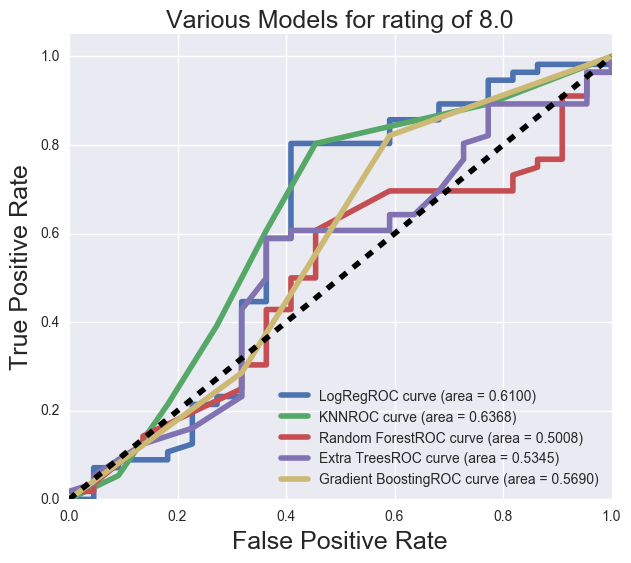

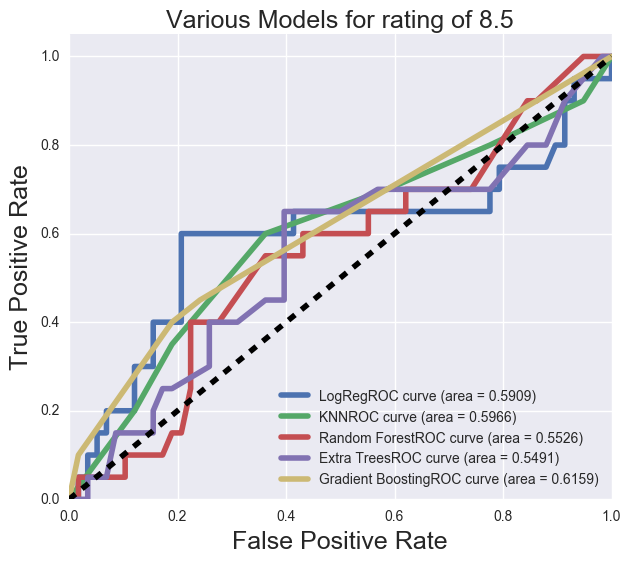

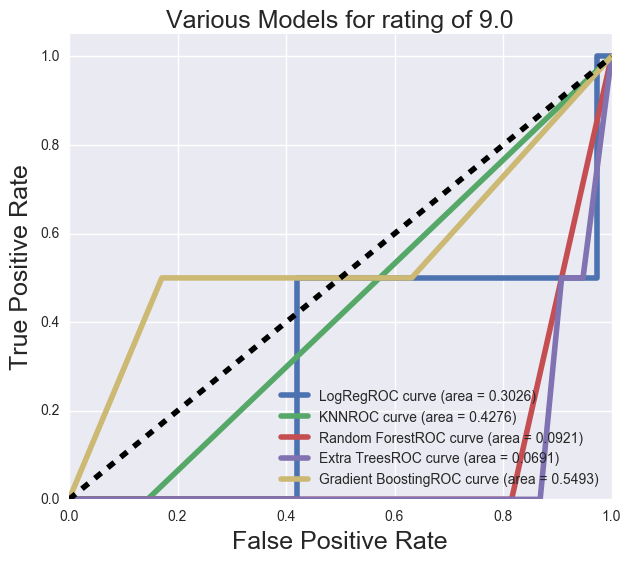

In [157]:
#We run through the gridsearch classifier formulas and find the following best results for a variety of classifiers
#For analysis, please refer to the blog post.
Super=True
Mega=True
Ultra=False
Actors=True
Production_Company=False
Producer=False
Editor=True
Composer=True
merged_dfs=merged_dfs_copy.copy()
X,y=create_X_y(Super,Mega,Ultra,Actors,Production_Company,Producer,Editor,Composer)

#---------

bins=3
x_train,x_test,y_train,y_test=train_test_split(X,binned_y(y,bins-1),random_state=1,\
                                               test_size=0.4)
lrbest,knbest,rfbest,etbest,gbbest,model_info=run_regressions_and_print(bins,x_train,x_test,y_train,y_test)
#plot_models(model_info,bins,y_test)                        
    
print 'Logistic Regression Best: ',lrbest
print 'K Nearest Neighbors Best: ',knbest
print 'Random Forest Best:       ',rfbest
print 'Extra Trees Best:         ',etbest
print 'Gradient Boosting Best:   ',gbbest

plot_models(model_info,bins,[beta/2. for beta in y_test])  

In [158]:
#Here are the non-gridsearch classification formulas. They demonstrate how an increased number of bins correspond
#to a decreased accuracy. This should always happen, as movie ratings for the 250 are within 0.5 rating points of 
#eachother; so binning values that are so close, like these, will always result in bad classification. One could try to
#compensate by feeding in many extra features, but this will result in over fitting.
Super=True
Mega=True
Ultra=False
Actors=True
Production_Company=True
Producer=True
Editor=True
Composer=True
merged_dfs=merged_dfs_copy.copy()
X,y=create_X_y(Super,Mega,Ultra,Actors,Production_Company,Producer,Editor,Composer)

#---------
for bins in range(4,8):
    print "\n \n Results for %s bins: \n"%bins
    x_train,x_test,y_train,y_test=train_test_split(X,binned_y(y,bins-1),random_state=1,\
                                                   test_size=0.4)
    lrbest,knbest,rfbest,etbest,gbbest,model_info=run_regressions_and_print_no_gs(bins,x_train,x_test,y_train,y_test)
#plot_models(model_info,bins,y_test)                        


 
 Results for 4 bins: 

LogReg Score:
    0.576923076923
Knn Score:
    0.525641025641
Random Forest Score:
    0.487179487179
                         Feature  Importance
0                     Box office    0.734865
2   Super Production Company_Yes   0.0535678
1               Super Actors_Yes   0.0390956
4               Super Editor_Yes   0.0301246
10             Mega Composer_Yes   0.0291458
9                Mega Editor_Yes   0.0260827
7    Mega Production Company_Yes   0.0245488
8              Mega Producer_Yes   0.0244928
6                Mega Actors_Yes   0.0231078
5             Super Composer_Yes  0.00810778
3             Super Producer_Yes  0.00686151
Extra Trees Score:
    0.448717948718
                         Feature  Importance
0                     Box office     0.76444
2   Super Production Company_Yes   0.0494609
1               Super Actors_Yes   0.0360748
7    Mega Production Company_Yes   0.0339996
6                Mega Actors_Yes   0.0244642
8              Mega Pro

/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:120: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:129: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Gradient Boosting Score:
    0.5
                         Feature  Importance
0                     Box office    0.767123
2   Super Production Company_Yes   0.0707426
1               Super Actors_Yes   0.0350284
6                Mega Actors_Yes    0.026018
4               Super Editor_Yes   0.0187996
9                Mega Editor_Yes   0.0182852
3             Super Producer_Yes   0.0179403
5             Super Composer_Yes   0.0159319
8              Mega Producer_Yes   0.0144556
10             Mega Composer_Yes   0.0142084
7    Mega Production Company_Yes  0.00146712

 
 Results for 5 bins: 



/Users/thomas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:139: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


LogReg Score:
    0.358974358974
Knn Score:
    0.320512820513
Random Forest Score:
    0.307692307692
                         Feature  Importance
0                     Box office    0.711775
7    Mega Production Company_Yes   0.0530135
2   Super Production Company_Yes   0.0454423
3             Super Producer_Yes   0.0383097
6                Mega Actors_Yes   0.0326502
9                Mega Editor_Yes   0.0287142
1               Super Actors_Yes   0.0274999
4               Super Editor_Yes   0.0229501
8              Mega Producer_Yes   0.0154719
5             Super Composer_Yes   0.0153623
10             Mega Composer_Yes  0.00881115
Extra Trees Score:
    0.333333333333
                         Feature Importance
0                     Box office   0.754841
2   Super Production Company_Yes  0.0519815
7    Mega Production Company_Yes  0.0418354
6                Mega Actors_Yes   0.031722
1               Super Actors_Yes   0.029659
8              Mega Producer_Yes  0.0209033
5          

In [136]:
#For analysis, please refer to the blog post

In [ ]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 35)